# Single-layer NN

Based on Karpathy's Makemore

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

# data preprocess

words = open('data/names.txt', 'r').read().splitlines()
print(len(words))
print(min(len(w) for w in words))
print(max(len(w) for w in words))
words[:8]

# build the vocabulary of characters and mappings to/from integers

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

# create the training set of bigrams (x,y)
xs, ys = [], []

for w in words[:1]:
  print(w)
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    print(ch1, ch2)
    xs.append(ix1)
    ys.append(ix2)
    
xs = torch.tensor(xs)
ys = torch.tensor(ys)

print('indices x:', xs)
print('indices y:', ys)

# convert it into ONE HOT ENCODING

import torch.nn.functional as F
xenc = F.one_hot(xs, num_classes=27).float()
print(xenc.shape)
xenc

32033
2
15
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27
emma
. e
e m
m m
m a
a .
indices x: tensor([ 0,  5, 13, 13,  1])
indices y: tensor([ 5, 13, 13,  1,  0])


tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

## NN implementation

### Neuron

In [ ]:
# estos son weights. Como cada ejemplo tiene 27 features, los weights de UNA neurona son 27
W = torch.randn((27, 1))
W

In [ ]:
# X*W = X1*W, X2*W, X3*W, X4*W, X5*W ---- (5, 27) @ (27, 1) -> (5, 1)
# cuando hacemos la matmul nos da 5 valores, uno para cada ejemplo. 
# los weights quedan fijos, lo que cambian son los inputs por los que se ejecutan

xenc @ W

### Layer

In [ ]:
# Si hacemos (27, 4) tenemos 27 "x" de input y 4 neuronas
# por lo que para cada neurona hay 27 conexiones, una para cada input
# las columnas serian cada neurona y las filas serian las conexiones de cada input a las neuronas

W = torch.randn((27, 4))
W

In [ ]:
# y ahora aca tenemos (5, 4) porque tenemos 5 ejemplos de 4 resultados cada uno (uno por cada neurona)
print((xenc @ W).shape)
xenc @ W

In [ ]:
# esto nos dice la activacion del 3er input (ejemplo index 2) en la 4ta neurona (neurona index 3)
(xenc @ W)[2, 3]

### Softmax

Para interpretar los resultados como probabilidades necesitamos que sean positivos y simular "counts" para despues normalizar y listo.

Como tenemos positivos y negativos, podemos considerar el resultado de las neuronas como log-counts y si les hacemos el .exp() quedan positivos. Los que eran negativos quedan menores a 1 y los positivos mayor a 1.

Despues los normalizamos y quedan como probabilidades.


---
Como todo este **forward pass es diferenciable**, lo podemos incluir en el modelo y calcular **backpropagar**

In [ ]:
# FORWARD PASS

logits = xenc @ W # log-counts. Pueden ser positivos o negativos
counts = logits.exp() # cuando hacemos exp() quedan positivos. Los que eran negativos quedan menores a 1 y los positivos mayor a 1.
print(counts)

# normalizamos para que queden entre 0 y 1 y sumen 1, a traves de las filas
probs = counts / counts.sum(1, keepdims=True)
probs

In [ ]:
# chequeamos que tengas las propiedades de probabilidades
print(probs[0])
print(probs[0].sum())

### Loss (negative log likelihood)

De nuevo, el loss esta constituido de todas **operaciones diferenciables**, entonces podemos **tunear los parametros para reducirlo**

In [ ]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g)

xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
# btw: the last 2 lines here are together called a 'softmax'

In [ ]:
nlls = torch.zeros(5)
for i in range(5):
  # i-th bigram:
  x = xs[i].item() # input character index
  y = ys[i].item() # label character index
  print('--------')
  print(f'bigram example {i+1}: {itos[x]}{itos[y]} (indexes {x},{y}) - input {x} - label {y}')
  p = probs[i, y]
  print('probability assigned by the net to the the correct character:', p.item())
  logp = torch.log(p)
  nll = -logp
  print('log likelihood:', logp.item(), "- negative log likelihood:", nll.item())
  nlls[i] = nll

print('\n=========')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())

### Regularization (smoothing)

In [ ]:
# REGULARIZATION: esto le da un "peso" a la loss que dice que es importante que los W sean lo mas cercanos a 0 posible.
# el 0.01 es el peso en la funcion de loss de este regularizador. (W**2).mean() es 0 loss cuando son todos 0 o cercano.

0.01*(W**2).mean()

## Training

with torch

### Manual

In [ ]:
# randomly initialize 27 neurons' weights. each neuron receives 27 inputs
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True) # requires_grad=True para que mantenga los grads

In [ ]:
# forward pass
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character

# loss (aca le pasamos los integers como vectores asi solo nos quedan las probs que nos interesan segun el target)
loss = -probs[torch.arange(5), ys].log().mean()
print(loss.item())

In [ ]:
# backward pass
W.grad = None # set to zero the gradient
loss.backward()

# update
W.data += -0.1 * W.grad

In [ ]:
# new forward pass
xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
logits = xenc @ W # predict log-counts
counts = logits.exp() # counts, equivalent to N
probs = counts / counts.sum(1, keepdims=True) # probabilities for next character

# loss (aca le pasamos los integers como vectores asi solo nos quedan las probs que nos interesan segun el target)
loss = -probs[torch.arange(5), ys].log().mean()
print(loss.item())

### Iterativo (with regularization)

Podemos modificar la loss para que los weights intenten TENDER A 0 y con eso hacer un **smoothing**

In [ ]:
# create the dataset
xs, ys = [], []
for w in words:
  chs = ['.'] + list(w) + ['.']
  for ch1, ch2 in zip(chs, chs[1:]):
    ix1 = stoi[ch1]
    ix2 = stoi[ch2]
    xs.append(ix1)
    ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print('number of examples: ', num)

# initialize the 'network'
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [ ]:
# gradient descent
for k in range(10):
  
  # forward pass
  xenc = F.one_hot(xs, num_classes=27).float() # input to the network: one-hot encoding
  logits = xenc @ W # predict log-counts
  counts = logits.exp() # counts, equivalent to N
  probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
  
  # loss with REGULARIZATION
  loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
  print(loss.item())
  
  # backward pass
  W.grad = None # set to zero the gradient
  loss.backward()
  
  # update
  W.data += -50 * W.grad

## Generation

In [ ]:
# finally, sample from the 'neural net' model
g = torch.Generator().manual_seed(2147483647)

for i in range(5):
  
  out = []
  ix = 0
  while True:
    
    # ----------
    # BEFORE:
    #p = P[ix]
    # ----------
    # NOW:
    xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
    logits = xenc @ W # predict log-counts
    counts = logits.exp() # counts, equivalent to N
    p = counts / counts.sum(1, keepdims=True) # probabilities for next character
    # ----------
    
    ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
    out.append(itos[ix])
    if ix == 0:
      break
  print(''.join(out))

# Simple MLP

- Tomamos 3 palabras o letras (context size), en realidad sus indices
- Tenemos lookup table (embedding matrix): matrix de vocab size by number of features del embedding. Con esto, agarramos un index y vamos a buscar a la matrix la fila correspondiente a esa palabra/letra y nos quedamos con el embedding vector
- Input layer: formado con la concatenacion de los 3 (o context size) embeddings de la embedding matrix para los inputs
- Hidden layer: con un tamaño variable, fully connected con el input layer
- Tanh layer?: Tiene un tanh non linearity
- Output layer: la cantidad de neurons es el vocab size porque vamos a tener una prob por word/token/letra. Esto genera los logits
- Softmax layer: que genera las probs (probability distribution) para el siguiente token

Parameters:
- weights and biases de output y hidden layer
- Matrix C (embedding matrix)

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

## Forward pass example

In [16]:
# read in all the words
words = open('data/names.txt', 'r').read().splitlines()
print(len(words))
print(words[:8])

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

# stoi -> pasar de string a index
stest = 'lucas'
print(f"string '{stest}' to indexes -> {[stoi[s] for s in stest]}")

# itos -> pasar de index a string
itest = [12, 21, 3, 1, 19]
print(f"index '{itest}' to string -> {''.join([itos[i] for i in itest])}")

# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
  
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix] # crop and append
  
X = torch.tensor(X)
Y = torch.tensor(Y)

32033
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
string 'lucas' to indexes -> [12, 21, 3, 1, 19]
index '[12, 21, 3, 1, 19]' to string -> lucas


In [17]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

Embedding table (C)

In [18]:
# 27 es el vocab size y 2 son los features del embedding
# cada row es una letra del vocab size

C = torch.randn((27, 2))
C

tensor([[-0.5065, -0.1056],
        [-1.1952,  0.5482],
        [-0.2357, -0.3087],
        [-0.5250, -0.4380],
        [ 0.4161,  1.1296],
        [ 0.4960, -0.9401],
        [-0.7872, -1.2590],
        [ 0.7437,  0.7817],
        [ 2.1096,  1.6686],
        [ 0.6591,  1.0068],
        [ 0.1091, -1.1839],
        [-1.6059,  1.2505],
        [ 0.7121,  0.8976],
        [-0.2768,  1.6821],
        [-1.3161, -0.7041],
        [-0.5414,  1.6827],
        [-1.5749,  1.2366],
        [-0.2391,  0.0552],
        [ 0.5329, -0.9595],
        [-0.0763, -0.7784],
        [ 0.4007, -1.1329],
        [-0.2191, -0.9184],
        [ 0.0454, -0.1044],
        [-0.2478, -1.6406],
        [ 1.9960,  0.4167],
        [ 0.7334,  0.9198],
        [-0.5952, -0.0228]])

In [19]:
# si tenemos uan letra (por ej "l" -> 12) podemos usar el index para retrieve el embedding
print(C[12])

# o primero hacer one-hot encoding y multiplicar el vector por la matrix para que los que son 0 se cancelen y quede solo el buscado
ohv = F.one_hot(torch.tensor(12), num_classes=27).float()
print(ohv @ C)

# tambien puedo indexar multiples tokens
print(C[[12, 2, 8]])
print(C[torch.tensor([12, 2, 8])])

# tambien puedo indexar multidimensional: multiples ejemplos con sus 3 de context
print(X.shape)
print(C[X])
print(C[X].shape)
print(f'Esto crea shape (4,3,2), o sea para cada ejemplo (4), para cada letra del ejemplo (3 por cada uno), va a buscar esa letra y trae el embedding (2 features)')

tensor([0.7121, 0.8976])
tensor([0.7121, 0.8976])
tensor([[ 0.7121,  0.8976],
        [-0.2357, -0.3087],
        [ 2.1096,  1.6686]])
tensor([[ 0.7121,  0.8976],
        [-0.2357, -0.3087],
        [ 2.1096,  1.6686]])
torch.Size([228146, 3])
tensor([[[-0.5065, -0.1056],
         [-0.5065, -0.1056],
         [-0.5065, -0.1056]],

        [[-0.5065, -0.1056],
         [-0.5065, -0.1056],
         [ 0.4960, -0.9401]],

        [[-0.5065, -0.1056],
         [ 0.4960, -0.9401],
         [-0.2768,  1.6821]],

        ...,

        [[-0.5952, -0.0228],
         [-0.5952, -0.0228],
         [ 0.7334,  0.9198]],

        [[-0.5952, -0.0228],
         [ 0.7334,  0.9198],
         [-0.5952, -0.0228]],

        [[ 0.7334,  0.9198],
         [-0.5952, -0.0228],
         [ 1.9960,  0.4167]]])
torch.Size([228146, 3, 2])
Esto crea shape (4,3,2), o sea para cada ejemplo (4), para cada letra del ejemplo (3 por cada uno), va a buscar esa letra y trae el embedding (2 features)


In [20]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

Hidden layer

In [21]:
# hacemos 6 de input (porque tenemos 3 de context size y 2 embeddings por letra)
# 100 neuronas

W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [22]:
# primero concateno la input layer (de la matrix C)
print(emb.view(-1, 6).shape) # cuando hago -1 el size lo infiere a partir del otro value

torch.Size([228146, 6])


In [23]:
# HAGO LA MULTIPLICACION @ PARA LA LAYER -> forward
# el resultado de esto es UN valor por cada neurona de la hidden (100 neuronas) y eso para cada ejemplo
# para cada ejemplo (32) voy a tener 100 outputs (uno de cada neurona)

L1 = emb.view(-1, 6) @ W1 + b1
print(L1.shape)

# y ahora le añado la activation function
h = torch.tanh(L1)
print(h.shape)
h

torch.Size([228146, 100])
torch.Size([228146, 100])


tensor([[ 0.8426, -0.1864, -0.7038,  ...,  0.6958, -0.5900,  0.7180],
        [ 0.1955, -0.7274, -0.9878,  ...,  0.0552,  0.8702,  0.1388],
        [-0.0379, -0.5107,  0.9825,  ...,  0.9871, -0.9883,  0.9732],
        ...,
        [-0.6903, -0.9416,  0.9860,  ...,  0.9902, -0.0748,  0.7901],
        [ 0.9526,  0.9726, -0.7242,  ..., -0.6917,  0.6972,  0.9926],
        [-0.6028, -0.9970, -0.8368,  ...,  0.9818,  0.9300, -0.6067]])

Output layer

In [24]:
# 100 de input porque es la salida de la hidden y 27 de output porque es el vocab size

W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [25]:
# calculo logits usando h que es la salida de la hidden layer y el output layer. 
# Este no tiene tanh porque va a tener softmax
# para cada ejemplo (32) quedan 27 outputs con los logits

logits = h @ W2 + b2
print(logits.shape)

torch.Size([228146, 27])


In [26]:
# calculo "counts" y probs (SOFTMAX)
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
# prob = F.softmax(logits, dim=1)
prob.shape

torch.Size([228146, 27])

Loss

In [27]:
# aca comparo con los Y posta
loss = -prob[torch.arange(len(Y)), Y].log().mean()
loss

tensor(18.0614)

## Training with mini-batches

### Dataset

In [ ]:
# read in all the words
words = open('data/names.txt', 'r').read().splitlines()
print(len(words))
print(words[:8])

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

# build the dataset
# devuelve X e Y que son los indices

def build_dataset(words, block_size=3):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y


import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

block_size = 3 # context length: how many characters do we take to predict the next one?

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

# Dataset
Xtr.shape, Ytr.shape

print(Xtr[0])

print('Xtr')
for x in Xtr[:10]:
    print(f"{x} -> {''.join([itos[i] for i in x.tolist()])}")
print('Ytr')
print(f"{Ytr[:10]} -> {[itos[i] for i in Ytr[:10].tolist()]}")

### NN initialization

In [ ]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility

# Matrix C
C = torch.randn((27, 10), generator=g)

# Hidden layer
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)

# Output layer
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)

# parameter list
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

# Setear los parametros con gradientes
for p in parameters:
  p.requires_grad = True

### Training

In [ ]:
# creo 1000 learning rates para despues hacer hiperparameter optimization
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre
print(lrs[:15])

def test_dev_set(C, emb, W1, b1, W2, b2):
    emb = C[Xdev]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ydev)
    return loss

In [ ]:
lri = []
lossi = []
# lossi_val = []
stepi = []

training_steps = 10000
minibatch_size = 32 # la cantidad de ejemplos que va a haber por mini batch

# PARA CADA ITERACION le vamos a mostrar un minibatch diferente (asi va a poder ver gran parte del dataset).
# Se hace por mini batches para no mostrarle todo el dataset de una y que el forward, backward y update sean muy costosos,
# porque aparte seria muy lento si se quisiera optimizar asi. Con mini batches vas updating los values mas seguido.

for i in range(training_steps):
  
  # minibatch construct (desde 0 hasta el ultimo ejemplo de Xtr, extraigo 32 indices)
  ix = torch.randint(0, Xtr.shape[0], (minibatch_size,))
  
  """forward pass"""
  # Matrix C: extraigo los embeddings de los ejemplos 
  emb = C[Xtr[ix]] # (32, 3, 10) -> extraigo 32 ejemplos (mini batch size) de Xtr
  # Hidden layer
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  # Output layer (genera logits)
  logits = h @ W2 + b2 # (32, 27)
  
  # Loss (uso cross entropy que es lo mismo que lo que hacia de softmax pero mas eficiente)
  loss = F.cross_entropy(logits, Ytr[ix]) # uso los indices de mini batch para extraer los valores de Y
  # loss_val = test_dev_set(C, emb, W1, b1, W2, b2) # Loss con validation set
  
  """backward pass""" 
  # inicializo los gradientes a 0/None
  for p in parameters:
    p.grad = None
  # calculo los gradientes con respecto a loss (de los que tienen requires_grad=True)
  loss.backward()
  
  """update""" 
  # seteo el learning rate a usar en esta iteracion
  #lr = lrs[i] # por el espacio de learning rates definido arriba -> esto se usa para hyperparameter optimization
  lr = 0.1 if i < 100000 else 0.01 # por regla fija (learning rate decay)
  # actualizo los valores de los parametros para minimizar loss
  for p in parameters:
    p.data += -lr * p.grad

  """track stats""" 
  #lri.append(lre[i]) # para ver que learning rate funciono mejor y setearlo
  stepi.append(i)
  lossi.append(loss.log10().item())
  # lossi_val.append(loss_val.log10().item())

# print(loss.item()) # es la loss del ultimo minibatch

### Testing

In [ ]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=stepi, y=lossi, mode='lines', name='Loss'))
fig.update_layout(
    title='Loss Across Iterations',
    xaxis_title='Iteration',
    yaxis_title='Loss')
fig.show()

In [ ]:
# TRAINING SET 

emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

In [ ]:
# DEV SET

emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

In [ ]:
# TEST SET

emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

### Generation

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

# Improvements & analysis

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

### Dataset

In [ ]:
# read in all the words
words = open('data/names.txt', 'r').read().splitlines()
words[:8]
print(len(words))

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

32033
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [ ]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


## Improvements

### Base MLP (previous)

In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility

# Matrix C (embeddings)
C  = torch.randn((vocab_size, n_embd),            generator=g)

# Hidden layer
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)

# Output layer
W2 = torch.randn((n_hidden, vocab_size),          generator=g)
b2 = torch.randn(vocab_size,                      generator=g)

# parameters and initialization
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


### Initial loss

Queremos que la probabilidad para cada token sea cercana a uniforme para que no le cueste tanto a la red ubicarse bien.

Si dejamos que sea todo random, puede crear una prob distribution en initialization que sea muy loca y con eso que le cueste mas despues entrenar.

In [ ]:
# si tenemos 27 posibles outputs y asumimos que empiezan todos con igual de prob 
# deberiamos tener una loss inicial cercana a:

- torch.tensor(1/27.0).log()

tensor(3.2958)

In [ ]:
# Nos fijamos solo el valor en inicializacion

# same optimization as last time
max_steps = 10
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
#   if i % 10000 == 0: # print every once in a while
#     print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  print(loss.item())
  lossi.append(loss.log10().item())

27.88172721862793
24.00319480895996
24.8073673248291
24.949344635009766
23.823497772216797
19.059768676757812
18.85730743408203
23.345325469970703
20.913820266723633
22.175315856933594


In [ ]:
# vemos que es muy alto (27) y eso es porque los logits son muy altos y variables
logits[0]

tensor([ 11.7716,  11.2583,  -2.1057,  12.2630,   6.0603, -26.3609,  -7.5310,
         10.5330,   1.2344,  21.8181,   3.8965, -17.3388,   0.2575,  -4.1627,
         -3.8200,   7.7143, -10.3872,  -0.4036,  20.7293,  12.9843,  10.6982,
         -1.3499,   8.1726,  -1.4742,  10.9682,  -8.9628,   9.2161],
       grad_fn=<SelectBackward0>)

In [ ]:
# Lo que queremos es que salgan logits mas cercanos a 0.as_integer_ratio
# Para eso, FORZAMOS a la salida de los logits (output layer) a que se achiquen al principio
# b2 = todos ceros. W2 = casi todo cero (un poco de entropy le dejamos)


# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility

# Matrix C (embeddings)
C  = torch.randn((vocab_size, n_embd),            generator=g)

# Hidden layer
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden,                        generator=g)

# Output layer
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # lo forzamos a casi todo 0 (dejamos un poco de entropia)
b2 = torch.randn(vocab_size,                      generator=g) * 0 # lo forzamos a todo 0 

# parameters and initialization
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [ ]:
# Nos fijamos solo el valor en inicializacion

# same optimization as last time
max_steps = 10
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
#   if i % 10000 == 0: # print every once in a while
#     print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  print(loss.item())
  lossi.append(loss.log10().item())

print("Ahora si inicializamos bien, con esto nos ahorramos los primeros steps que aplastan los logits")

3.322058916091919
3.1857101917266846
3.1329591274261475
3.0528512001037598
3.1373000144958496
2.9710917472839355
2.857463836669922
2.936943531036377
2.7543795108795166
2.988801956176758


### Activations of hidden layer

Ahora la inicializacion del loss parece bien pero hay otro problema mas oculto, las activaciones del hidden state tienen problemas.

---
**Tanh es una squashing function** que toma valores arbitrarios y los transforma en rango -1, 1.

Entonces si las pre activaciones (antes del tanh) son muy altos o bajos, muchos van a quedan en -1 o 1 cuando se pase por tanh.
Y el problema ahi es que despues **va a ser muy dificil sacar de ahi en el entrenamiento**


In [ ]:
# como vemos, hay muchos valores en 1 o -1 en la salida del hidden layer
h

tensor([[ 0.7863, -0.5213, -0.9999,  ..., -0.9998,  0.9999,  0.9462],
        [-0.3713,  0.2082,  1.0000,  ...,  0.6958,  0.2010,  0.9998],
        [-1.0000, -0.9941, -1.0000,  ..., -1.0000, -0.9995,  1.0000],
        ...,
        [-0.0156, -0.9214, -1.0000,  ...,  1.0000, -1.0000, -1.0000],
        [-1.0000,  0.8558, -0.9996,  ...,  0.6107,  0.9995,  0.9948],
        [-0.8651, -0.9998, -0.9969,  ..., -0.9997, -0.9657, -0.9662]],
       grad_fn=<TanhBackward0>)

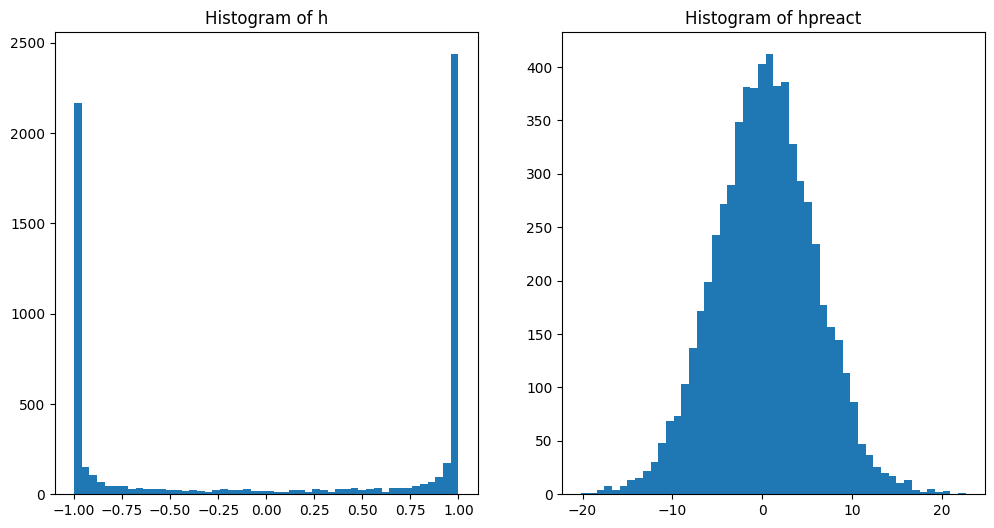

In [ ]:
# visualizo las activaciones y pre activaciones y vemos 
# en las preactivaciones hay muchos valores altos o bajos (muy broad) 
# entonces cuando se hace el tanh quedan saturados

h_list = h.view(-1).tolist()
hpreact_list = hpreact.view(-1).tolist()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.hist(h_list, 50)
ax1.set_title('Histogram of h')
ax2.hist(hpreact_list, 50)
ax2.set_title('Histogram of hpreact')
plt.show()

#### Por que tanh saturado es malo

Tiene que ver con como se hace backprop.

Para tanh, el _backward() es:

```python
self.grad += (1 - t**2) * out.grad
```
t es el resultado del tanh.

 Por lo que:
- Si t = 1, tenemos 0. Matamos el gradient y no pasa nada por el backprop
- Si t = -1, tambien tenemos 0. Matamos el gradient y no pasa nada por el backprop

Esto es porque el tanh es como la sigmoid, si es -1 o 1, estamos en la cola que es casi flat, entonces la derivada es 0.

Estamos matando a muchas neuronas, haciendolas inactivas asi.

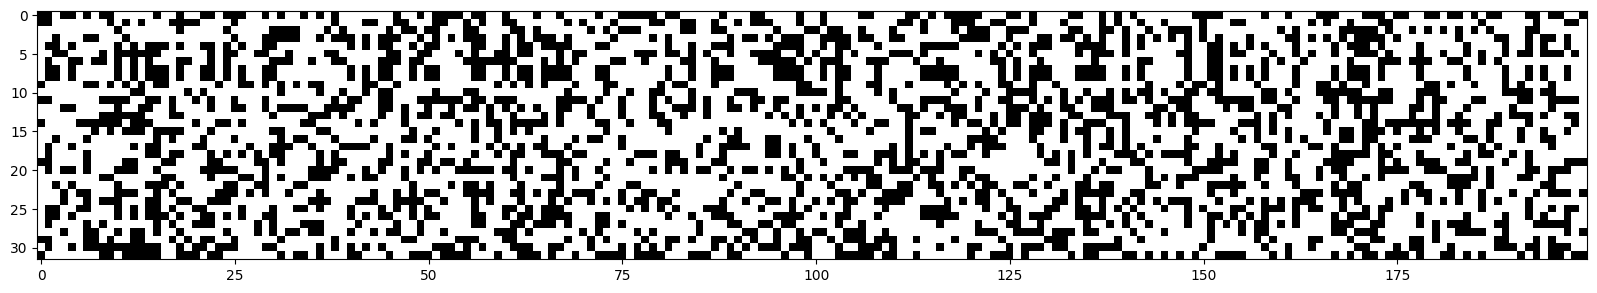

In [ ]:
# si queremos ver cuantas veces cae en la region "flat" >0.99 o <0.99, vemos asi
# filas son los ejemplos y columnas son las neuronas (activaciones)
# todas las que sean blancas son flat!
"""si toda una columna esta en blanco es lo que se llama "dead neuron", una que esta completamente inactiva y no puede reactivarse.
Cuando ningun ejemplo cae en los tails y entonces no aprende nunca """
# esto no solo puede pasar por inicializacion sino que tambien puede ser en el entrenamiento, si el learning rate es muy alto
# y el gradiente se va a la mierda, se puede morir la neurona porque queda en los tails.
"""Y esto no solo pasa con tanh sino que tambien con sigmoid, relu y muchas otras (las que tengan sectores flat)"""

plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

In [ ]:
# Para solucionarlo, FORZAMOS a que sean mas cercanos a 0 tambien en h

# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility

# Matrix C (embeddings)
C  = torch.randn((vocab_size, n_embd),            generator=g)

# Hidden layer
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2 # NUEVO
b1 = torch.randn(n_hidden,                        generator=g) * 0.01 # NUEVO

# Output layer
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01 # lo forzamos a casi todo 0 (dejamos un poco de entropia)
b2 = torch.randn(vocab_size,                      generator=g) * 0 # lo forzamos a todo 0 

# parameters and initialization
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [ ]:
# Nos fijamos solo el valor en inicializacion

# same optimization as last time
max_steps = 1
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
#   if i % 10000 == 0: # print every once in a while
#     print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  print(loss.item())
  lossi.append(loss.log10().item())

3.3134593963623047


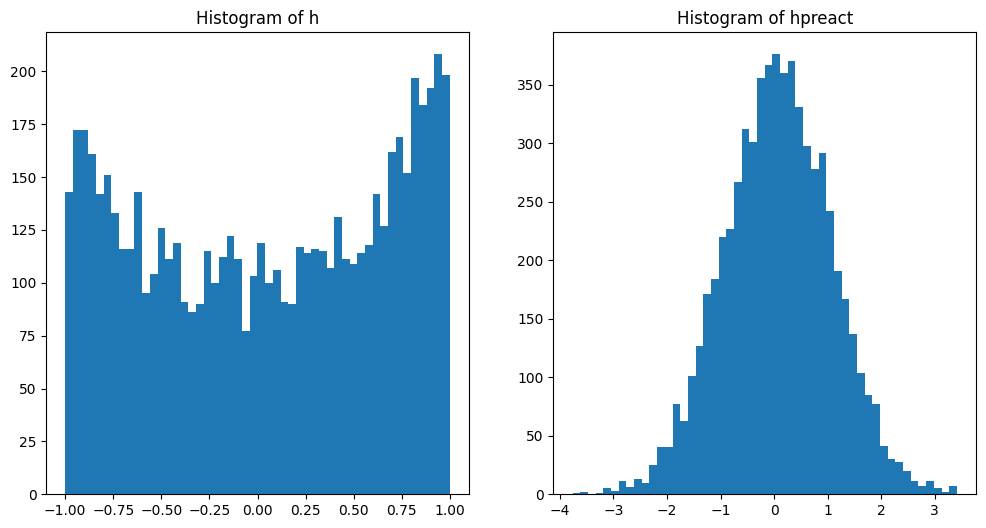

In [ ]:
# AHORA SI queda bien

h_list = h.view(-1).tolist()
hpreact_list = hpreact.view(-1).tolist()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.hist(h_list, 50)
ax1.set_title('Histogram of h')
ax2.hist(hpreact_list, 50)
ax2.set_title('Histogram of hpreact')
plt.show()

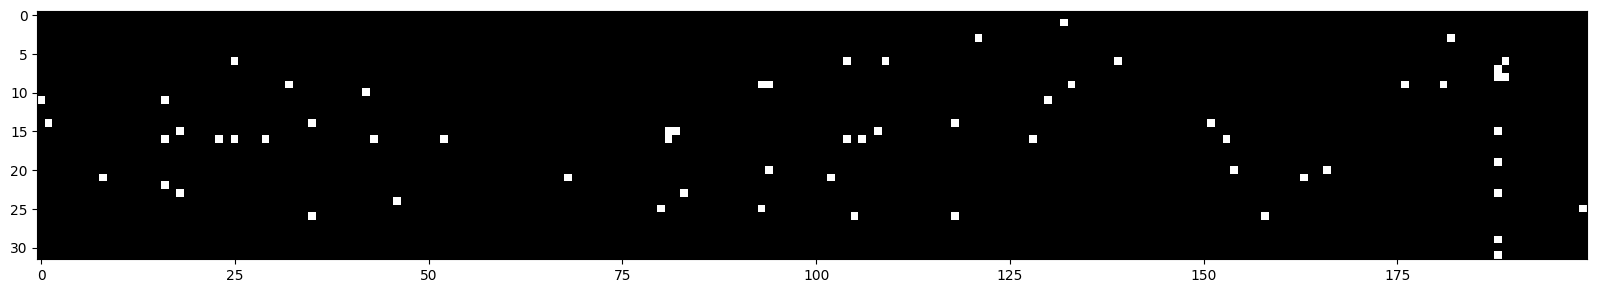

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

### Mantener el std de los logits

Cuando tenemos x que son standard normal distribution y tambie w que son standard normal dist, y **los multiplicamos, queda el mean en 0 pero aumenta el std**.
Entonces eso puede ser un problema. 

Para solucionarlo, hay que "achicar" los W para que la multiplicacion quede como un standard normal dist!

In [ ]:
# si vemos esto, al multiplicar dos matrices de standard normal, 
# nos queda una con mean 0 pero std muy alto

x = torch.randn(1000, 100)
w = torch.randn(100, 1000)
y = x @ w 

print('x', x.mean(), x.std())
print('w', w.mean(), w.std())
print('y', y.mean(), y.std())

x tensor(0.0012) tensor(0.9994)
w tensor(-0.0019) tensor(1.0035)
y tensor(0.0040) tensor(10.0284)


In [ ]:
# para solucionarlo, escalamos W por un factor

x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5 # 10 porque es el number of inputs
y = x @ w 

print('x', x.mean(), x.std())
print('w', w.mean(), w.std())
print('y', y.mean(), y.std())

x tensor(0.0045) tensor(1.0028)
w tensor(-0.0005) tensor(0.3110)
y tensor(-0.0033) tensor(0.9871)


### Gain: Kaiming init (mejor forma de inicializar)

Depende de la activation function.

Usa un **gain** para compensar la propiedad de comprimir que tienen estas funciones.

Para tanh, el gain seria 5/3, entonces:

$$
std = \frac{gain}{\sqrt{FanMode}}
$$


In [ ]:
# Cambiamos los W1 por el kaiming init

# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility

# Matrix C (embeddings)
C  = torch.randn((vocab_size, n_embd),            generator=g)

# Hidden layer
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) # NUEVO
b1 = torch.randn(n_hidden,                        generator=g) * 0.01

# Output layer
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# parameters and initialization
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

### Batch Normalization

Lo que buscamos es lo mismo que siempre: **pre activaciones chiquitas (para que el tanh no sature) y similares a gaussian(0,1)**.

Si queremos hidden states que sean gaussian, por que no las transformamos en gaussian y listo? Eso es batch norm.

---
Para transformarlas en gaussian, se tiene que restar a algo y dividir a algo, y eso es a la mean y a la std de un grupo. Entonces **se usa el batch de ejemplos para estas estadisticas**.

$$
 Z = \frac{X - \mu}{\sigma} 
$$

Se puede hacer porque todo es perfectamente diferenciable.


Esto no esta bueno porque de alguna manera "acopla" multiples ejemplos que deberian ser independientes, pero tambien **acoplar los ejemplos del batch sirve para normalizar de alguna manera**. 

---
Asi que sirve appendear una batchnorm layer despues de una linear layer

In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility

# Matrix C (embeddings)
C  = torch.randn((vocab_size, n_embd),            generator=g)

# Hidden layer
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden,                        generator=g) * 0.01

# Output layer
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# parameters and initialization
parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

11897


In [ ]:
# same optimization as last time
max_steps = 1
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  hpreact = embcat @ W1 + b1 # hidden layer pre-activation
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
#   if i % 10000 == 0: # print every once in a while
#     print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  print(loss.item())
  lossi.append(loss.log10().item())

3.3179006576538086


In [ ]:
print(hpreact.shape)
print(h.shape)

torch.Size([32, 200])
torch.Size([32, 200])


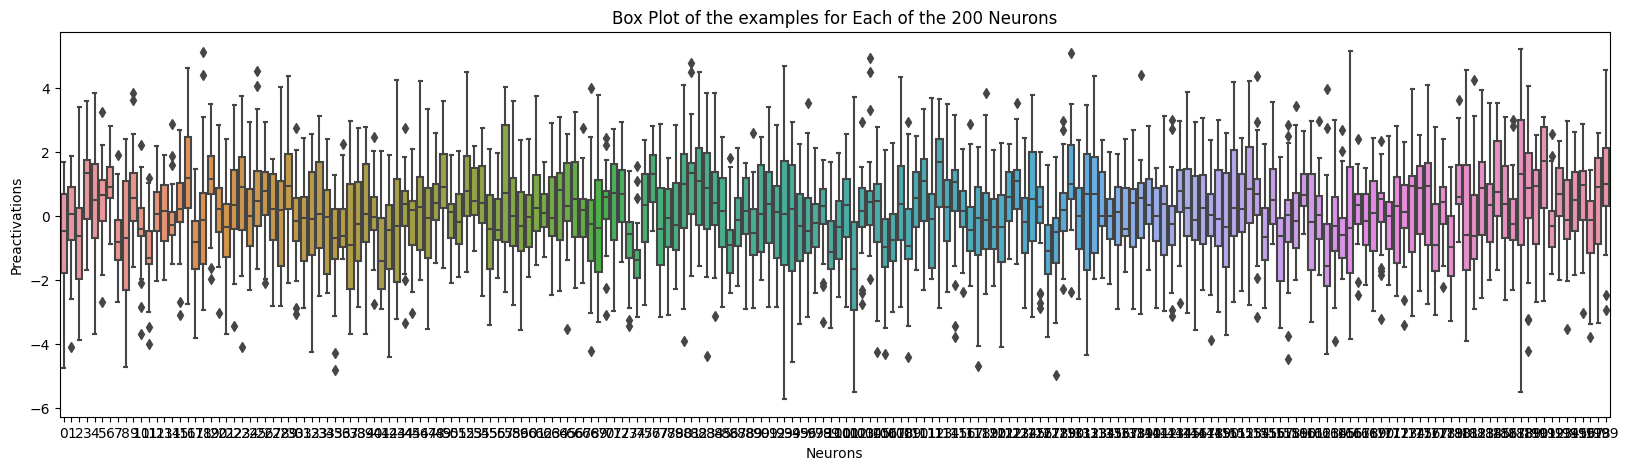

In [ ]:
# Analizamos la distribucion (de las preactivaciones de los 32 ejemplos) para cada neurona 

import seaborn as sns

h_numpy = hpreact.detach().numpy()

plt.figure(figsize=(20, 5))
sns.boxplot(data=h_numpy)
plt.title("Box Plot of the examples for Each of the 200 Neurons")
plt.xlabel("Neurons")
plt.ylabel("Preactivations")
plt.show()


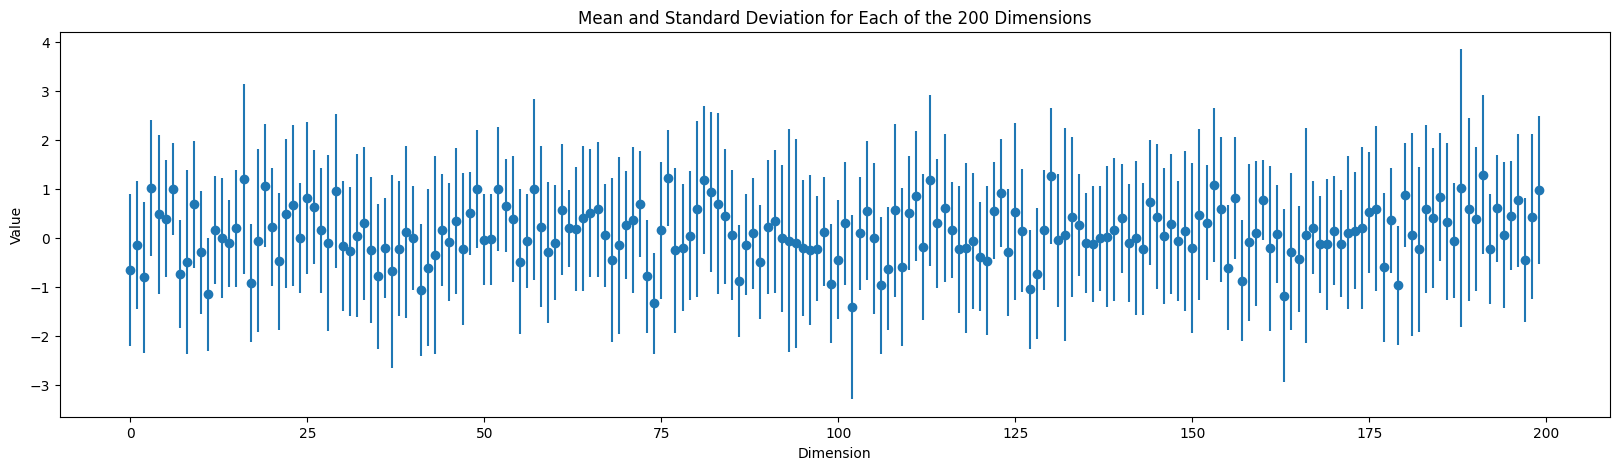

In [ ]:
import numpy as np 
# Assuming 'h' is your PyTorch tensor of shape (32, 200)
h_numpy = hpreact.detach().numpy()

# Calculate mean and standard deviation for each dimension
means = np.mean(h_numpy, axis=0)
stds = np.std(h_numpy, axis=0)
dimensions = np.arange(200)  # 200 dimensions

# Create a plot
plt.figure(figsize=(20, 5))
plt.errorbar(dimensions, means, yerr=stds, fmt='o') # 'o' specifies the marker type

plt.title("Mean and Standard Deviation for Each of the 200 Dimensions")
plt.xlabel("Dimension")
plt.ylabel("Value")
plt.show()


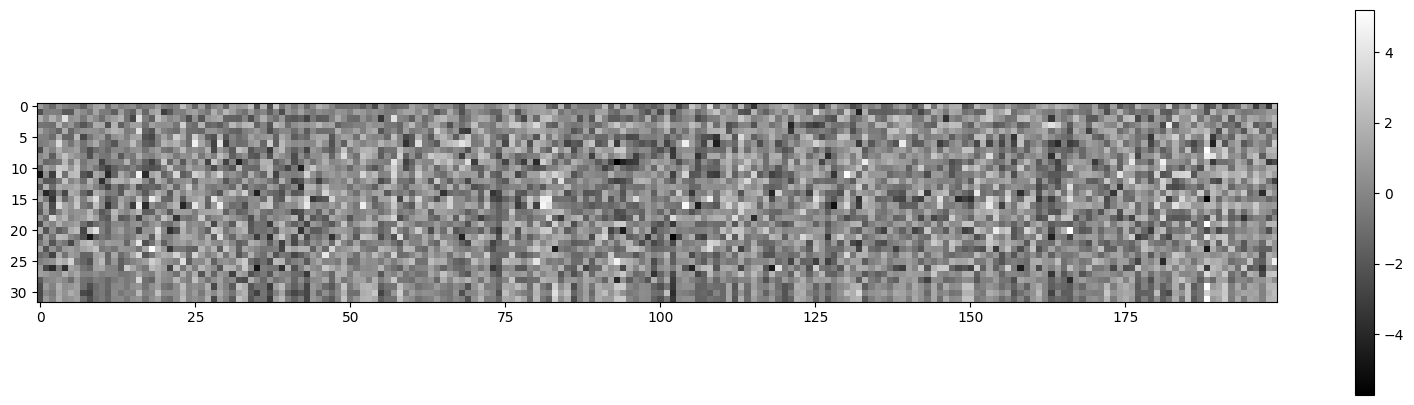

In [ ]:
h_numpy = hpreact.detach().numpy()
plt.figure(figsize=(20,5))
plt.imshow(h_numpy, cmap='gray', interpolation='nearest')
plt.colorbar() 

# Show the plot
plt.show()

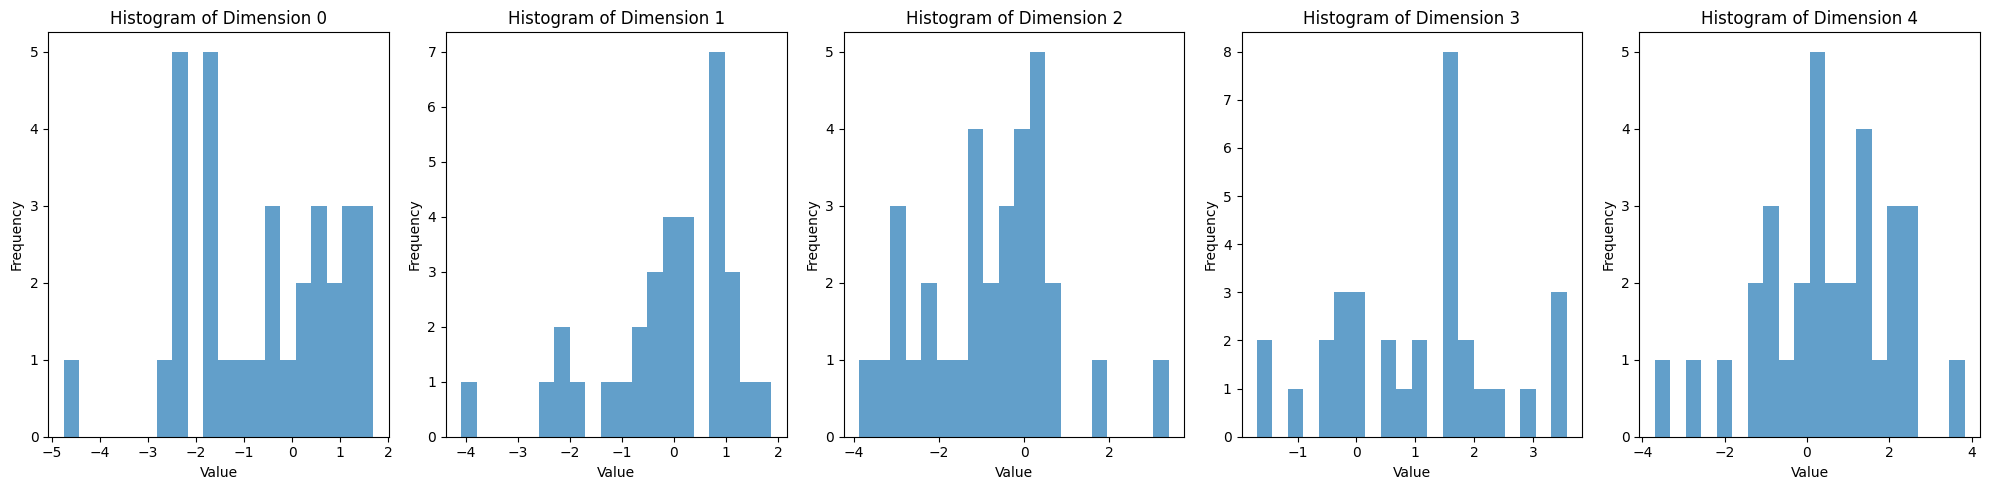

In [ ]:
# vemos algunas neuronas a ver la distribucion que tienen

selected_dims = range(5)
plt.figure(figsize=(20, 5))

for i, dim in enumerate(selected_dims, 1):
    plt.subplot(1, len(selected_dims), i)
    plt.hist(h_numpy[:, dim], bins=20, alpha=0.7)
    plt.title(f'Histogram of Dimension {dim}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


#### Objetivo: Estandarizar por batch
Lo que queremos es, para cada columna (neurona en la hidden layer) estandarizar a traves de las filas para que queden con formato gaussian 0,1.

$$
 Z = \frac{X - \mu}{\sigma} 
$$

In [ ]:
# tenemos un mean y un std por neurona
print(hpreact.mean(0, keepdim=True).shape)
print(hpreact.std(0, keepdim=True).shape)

bnmeani = hpreact.mean(0, keepdim=True)
bnstdi = hpreact.std(0, keepdim=True)

# ACA hacemos la estandarizacion
hpreact_standard = (hpreact - bnmeani) / bnstdi
hpreact_standard.shape

torch.Size([1, 200])
torch.Size([1, 200])


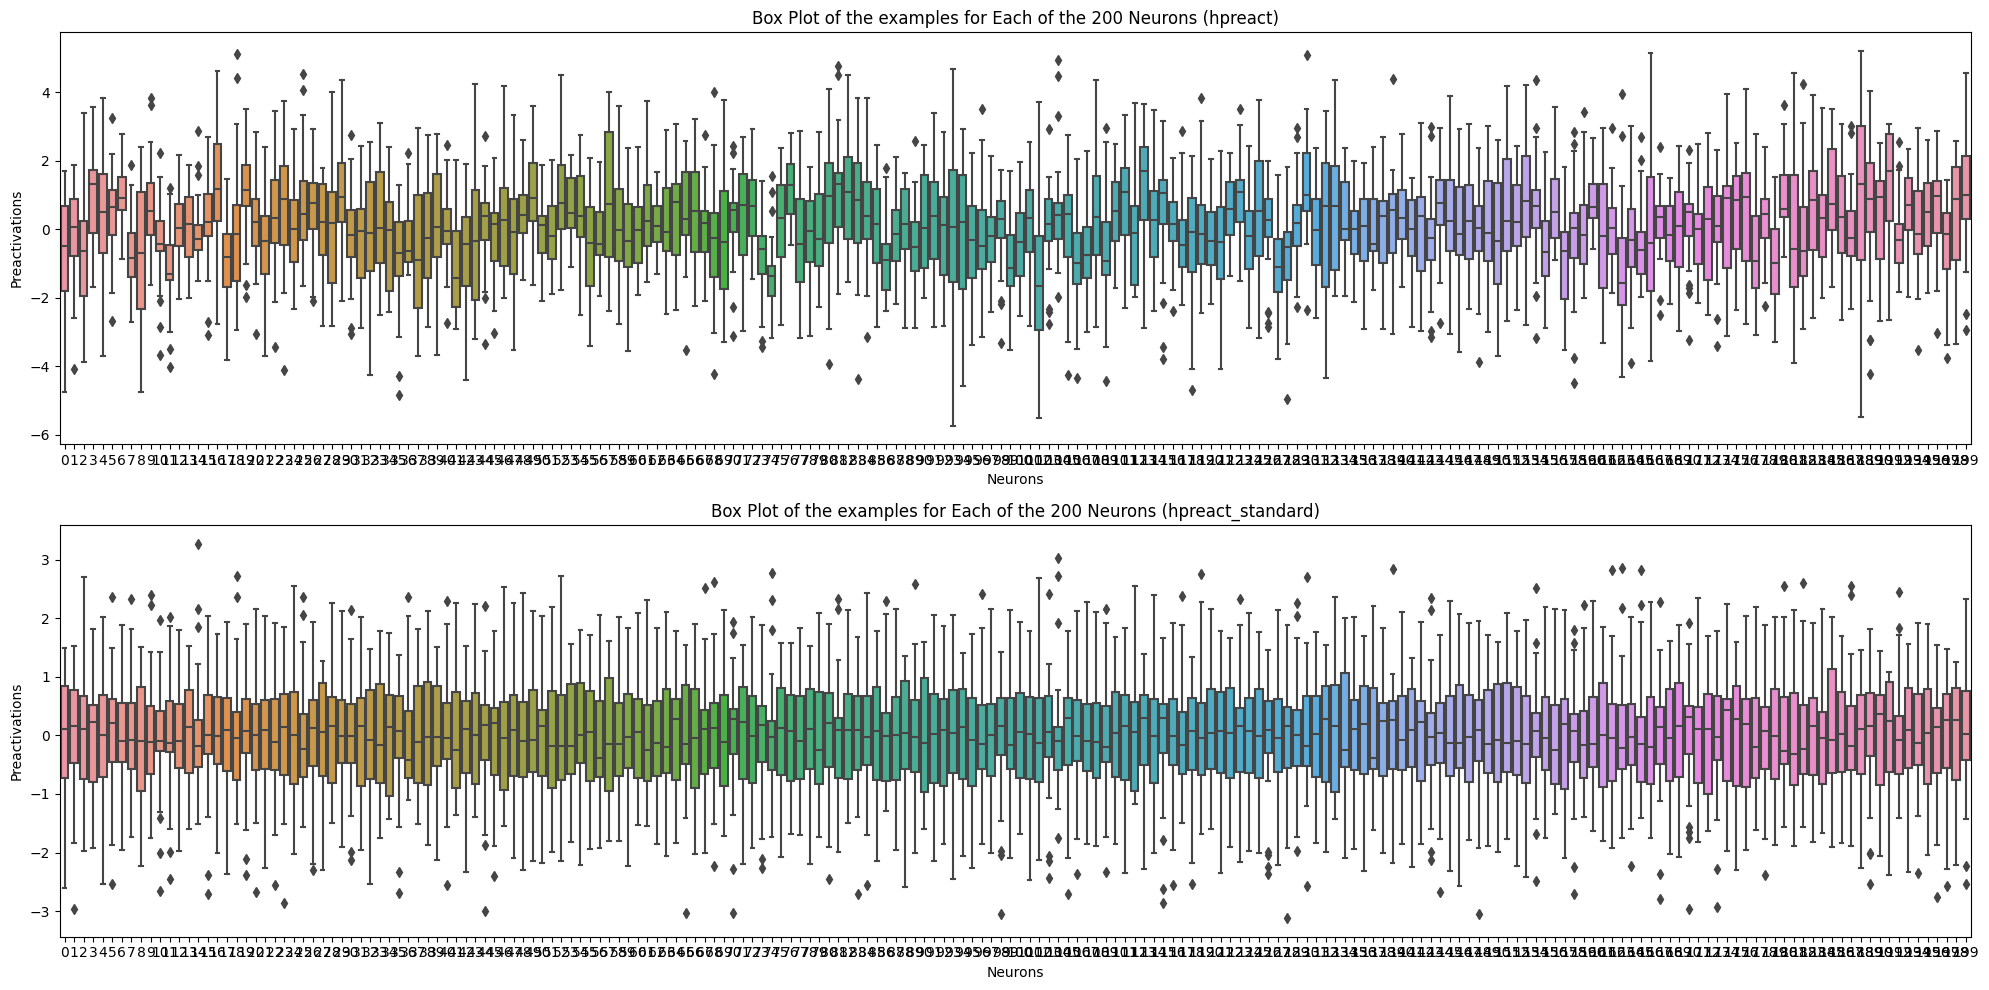

In [ ]:
# Comparandolo con lo anterior

hpreact_numpy = hpreact.detach().numpy()
hpreact_standard_numpy = hpreact_standard.detach().numpy()

fig, axs = plt.subplots(2, 1, figsize=(20, 10))

# First subplot for 'hpreact'
sns.boxplot(data=hpreact_numpy, ax=axs[0])
axs[0].set_title("Box Plot of the examples for Each of the 200 Neurons (hpreact)")
axs[0].set_xlabel("Neurons")
axs[0].set_ylabel("Preactivations")

# Second subplot for 'hpreact_standard'
sns.boxplot(data=hpreact_standard_numpy, ax=axs[1])
axs[1].set_title("Box Plot of the examples for Each of the 200 Neurons (hpreact_standard)")
axs[1].set_xlabel("Neurons")
axs[1].set_ylabel("Preactivations")

plt.tight_layout()
plt.show()

#### Scale+Shift: Permitir aprender (solo standard en init)

Si forzamos siempre los hpreact para ser gaussian, le va a costar aprender porque no se va a poder mover nunca!

Entonces lo que queremos es: **Solo standard en inicializacion. Despues permitir mover**.

---
Le agregamos como parametros (APRENDIBLES) al modelo:
- Gain (scale): inicializado en 1 para que sea gaussian
- Bias (shift): inicializado en 0 para que sea gaussian


#### Inicializamos NN con batchnorm

In [ ]:
"""
Aca agregamos los BatchNorm parameters 
"""

# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility

# Matrix C (embeddings)
C  = torch.randn((vocab_size, n_embd),            generator=g)

# Hidden layer
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01

# Output layer
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

"""
Gain y bias son parametros que se inicializan en 0 y 1 para que:
- En inicializacion los hpreact sean gaussian
- Despues tengan forma de mover y escalar la distribucion para que pueda aprender
"""
# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

# parameters and initialization
parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [ ]:
# same optimization as last time
max_steps = 100
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  
  # BatchNorm layer
  """Entre la linear layer y el tanh (non linearity) agregamos la batchnorm layer"""
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  # -------------------------------------------------------------
  
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  

      0/    100: 2.3378


In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  # hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.363480806350708
val 2.3645756244659424


#### Inference: Running mean and std 

Si queremos hacer inferencia con un solo ejemplo, como lo hacemos si **necesitamos el mean y std del batch??? Ahora no tenemos batch**.

---
Tenemos que **calcular un mean y std general (de todo training set) de toda la red para despues usar para hacer inferencia**


Post entrenamiento

In [ ]:
# Podemos calibrar el batch norm al final del entrenamiento asi
# y que ya queden. Pero es FEO esto. Queremos que se haga solo

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

Running (durante entrenamiento)

In [ ]:
"""
Añadimos bnmean_running y bnstd_running
para que se vayan calculando a medida que entrenamos la red y que ya queden
"""

# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility

# Matrix C (embeddings)
C  = torch.randn((vocab_size, n_embd),            generator=g)

# Hidden layer
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2

# Output layer
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
"""Inicializamos los running mean and std"""
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

# parameters and initialization
parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [ ]:
# same optimization as last time
max_steps = 1000
batch_size = 32
lossi = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  """Ahora el b1 no hace nada porque tenemos batch norm y cuando se hace la resta
  se lleva a 0 entonces no hace nada, lo sacamos. Queda el bnbias que tiene el mismo efecto"""
  
  # BatchNorm layer
  # -------------------------------------------------------------
  """bnmeani y bnstdi es para cada i (cada iteracion)"""
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  """running son general (no hacen nada en el proceso sino que se van calculando on the side)"""
  with torch.no_grad(): # porque no van a ser parte del proceso!
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani # le agregamos un small update cada step
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi # le agregamos un small update cada step
  # -------------------------------------------------------------
  
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  

      0/   1000: 3.3239


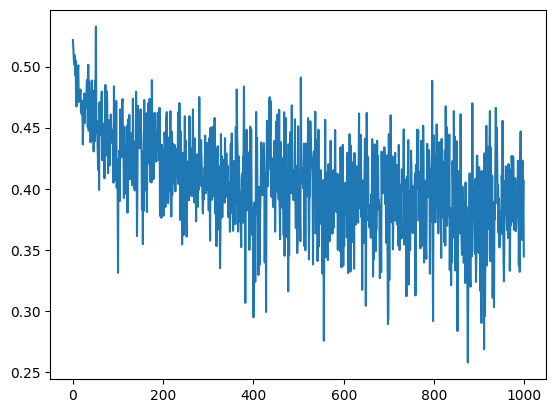

In [ ]:
plt.plot(lossi)

In [ ]:
print(bnmean_running.shape)
print(bnstd_running.shape)

torch.Size([1, 200])
torch.Size([1, 200])


In [ ]:
# PARA INFERENCE (ahora podemos pasarle un solo ejemplo)

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  """Aca le añado los running parameters de batch norm"""
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias # aca los usamos a los generales
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.457094430923462
val 2.454827070236206


# Deeper NN

### Classes

In [ ]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


In [ ]:
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

In [ ]:
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

### No BatchNorm

#### Sin gain

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
  """
  Estabilizacion de la red:
  Se escalan los outputs de las layers para ir estabilizando la red.
  - output layer: se hace mas bajo para que sea menos confident
  - hidden layers: se aplica el gain para contrarrestar la propiedad del tanh que es de shrinking (compactar) : 5/3
  """
  # last layer: make less confident
  layers[-1].weight *= 0.1 # NUEVO
  # all other layers: apply gain (kaiming init)
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1 #5/3 ACA NO APLICAMOS GAIN PARA VER QUE PASA

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

46497


In [ ]:
# same optimization as last time
max_steps = 10_000
batch_size = 32
lossi = []
ud = []  # NUEVO: update/data (para ver la escala del update comparado a la data)

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  """retain the gradient for a specific tensor. 
  Normally, PyTorch only keeps gradients for leaf nodes in the computation graph, which are typically the parameters of your model. 
  Non-leaf tensors are the results of operations in your network (like the output of a layer)."""
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters]) # NUEVO: update/data (para ver la escala del update comparado a la data)

  break # AFTER_DEBUG: would take out obviously to run full optimization

      0/  10000: 3.2988


layer 1 (      Tanh): mean -0.02, std 0.62, saturated: 3.50%
layer 3 (      Tanh): mean -0.00, std 0.48, saturated: 0.03%
layer 5 (      Tanh): mean +0.00, std 0.41, saturated: 0.06%
layer 7 (      Tanh): mean +0.00, std 0.35, saturated: 0.00%
layer 9 (      Tanh): mean -0.02, std 0.32, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

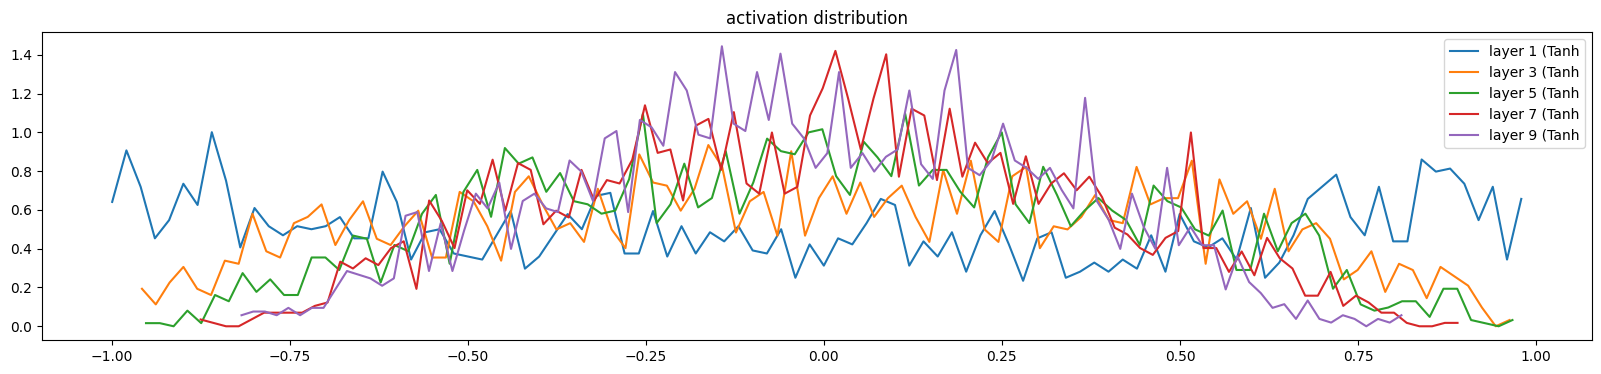

In [ ]:
# visualize histograms (para los tanh layers).
"""
Sin el gain, como vemos, layer 1 esta bien pero despues 
las demas layersempiezan a tener muchos valores cercanos a 0 (shrinking por el tanh).
Entonces necesitamos el GAIN para que no tenga este efecto de squashing (y pelear el efecto).
"""

plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean +0.000003, std 1.753627e-04
layer 3 (      Tanh): mean -0.000003, std 2.183582e-04
layer 5 (      Tanh): mean +0.000009, std 2.588459e-04
layer 7 (      Tanh): mean +0.000017, std 2.806324e-04
layer 9 (      Tanh): mean -0.000014, std 3.054209e-04


Text(0.5, 1.0, 'gradient distribution')

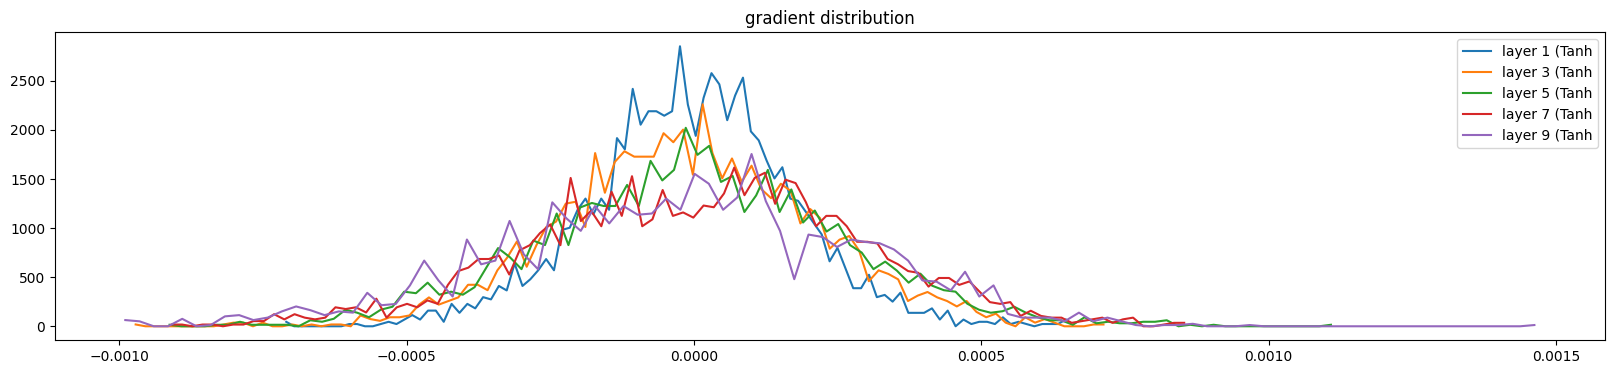

In [ ]:
"""
Aca tambien sin el gain los gradientes estan mas dispersos entre las layers 
y se estan medio descontrolando. Lo que hay que hacer es que esten todos mas estables.
"""

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000006 | std 4.592150e-04 | grad:data ratio 4.588830e-04
weight  (30, 100) | mean -0.000018 | std 7.035796e-04 | grad:data ratio 3.760086e-03
weight (100, 100) | mean +0.000008 | std 6.381747e-04 | grad:data ratio 6.402723e-03
weight (100, 100) | mean -0.000003 | std 6.533305e-04 | grad:data ratio 6.485942e-03
weight (100, 100) | mean -0.000006 | std 6.413855e-04 | grad:data ratio 6.394114e-03
weight (100, 100) | mean -0.000005 | std 5.877662e-04 | grad:data ratio 5.853900e-03
weight  (100, 27) | mean -0.000000 | std 1.196617e-02 | grad:data ratio 1.203068e+00


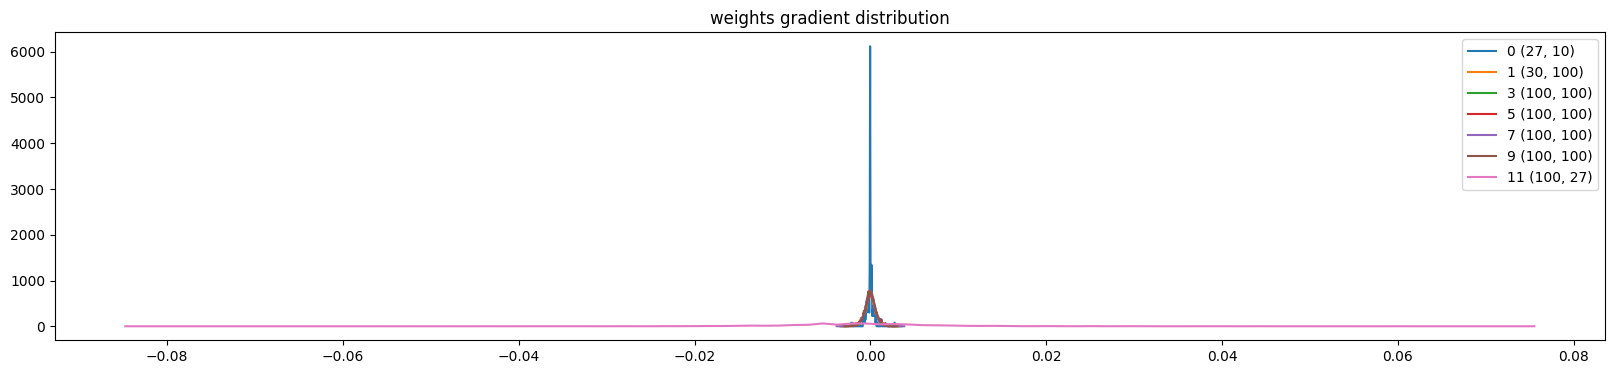

In [ ]:
"""
Solo estoy viendo los weights (no biases ni gammas ni betas of batchnorm)
Aca estamos viendo el ratio de gradient to data (a ver si los gradient son muy chicos o grandes comparados con los values posta)
"""


# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

#### Con gain

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size),
]

with torch.no_grad():
  """
  Estabilizacion de la red:
  Se escalan los outputs de las layers para ir estabilizando la red.
  - output layer: se hace mas bajo para que sea menos confident
  - hidden layers: se aplica el gain para contrarrestar la propiedad del tanh que es de shrinking (compactar) : 5/3
  """
  # last layer: make less confident
  layers[-1].weight *= 0.1 # NUEVO
  # all other layers: apply gain (kaiming init)
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

46497


In [ ]:
# same optimization as last time
max_steps = 10_000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  """retain the gradient for a specific tensor. 
  Normally, PyTorch only keeps gradients for leaf nodes in the computation graph, which are typically the parameters of your model. 
  Non-leaf tensors are the results of operations in your network (like the output of a layer)."""
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/  10000: 3.2962


layer 1 (      Tanh): mean -0.04, std 0.76, saturated: 21.97%
layer 3 (      Tanh): mean -0.01, std 0.72, saturated: 11.00%
layer 5 (      Tanh): mean +0.01, std 0.73, saturated: 13.00%
layer 7 (      Tanh): mean -0.05, std 0.73, saturated: 13.34%
layer 9 (      Tanh): mean +0.00, std 0.72, saturated: 10.53%


Text(0.5, 1.0, 'activation distribution')

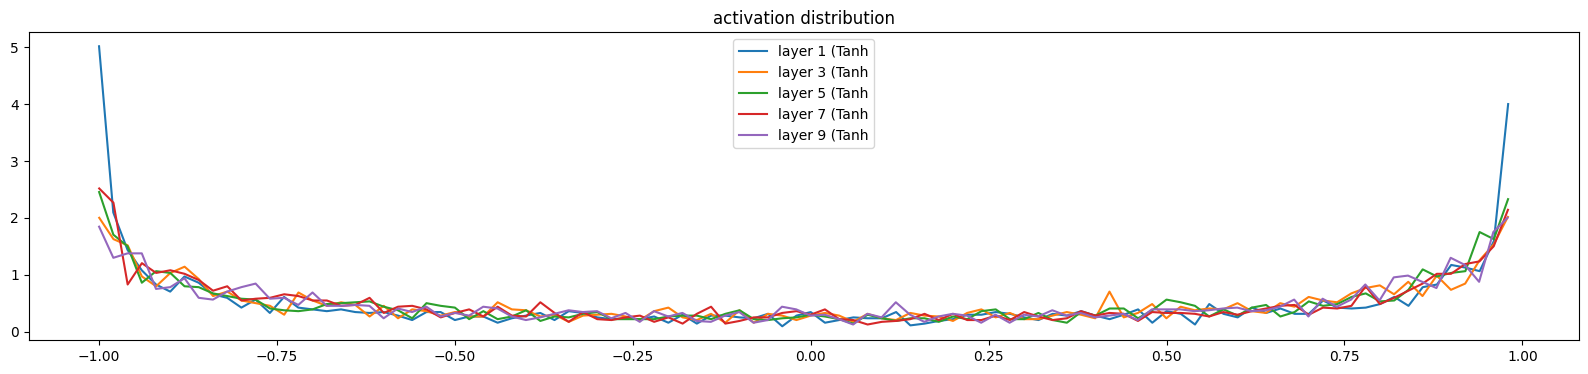

In [ ]:
# visualize histograms (para los tanh layers).
# Con esto vemos que si bien layer 1 tiene bastantes valores saturados (-1 o 1), las demas layers no, y esta bien
# Y el std es estable. Esto se produce porque el gain es 5/3 que es un buen numero (no se de dodne sale)

plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean +0.000024, std 3.353991e-03
layer 3 (      Tanh): mean +0.000012, std 3.157344e-03
layer 5 (      Tanh): mean -0.000004, std 2.925863e-03
layer 7 (      Tanh): mean +0.000036, std 2.715700e-03
layer 9 (      Tanh): mean +0.000020, std 2.308167e-03


Text(0.5, 1.0, 'gradient distribution')

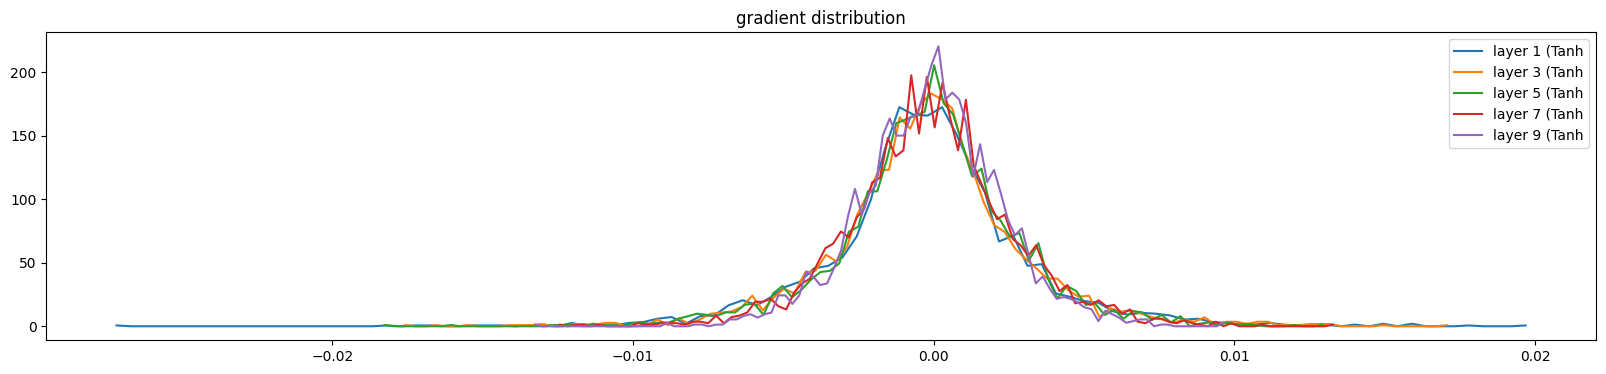

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000980 | std 1.189171e-02 | grad:data ratio 1.189149e-02
weight  (30, 100) | mean +0.000118 | std 1.005290e-02 | grad:data ratio 3.214555e-02
weight (100, 100) | mean +0.000033 | std 7.821212e-03 | grad:data ratio 4.653362e-02
weight (100, 100) | mean -0.000107 | std 6.655621e-03 | grad:data ratio 3.925852e-02
weight (100, 100) | mean -0.000017 | std 6.086040e-03 | grad:data ratio 3.605768e-02
weight (100, 100) | mean -0.000077 | std 5.075620e-03 | grad:data ratio 3.015269e-02
weight  (100, 27) | mean +0.000000 | std 2.056585e-02 | grad:data ratio 2.909911e-01


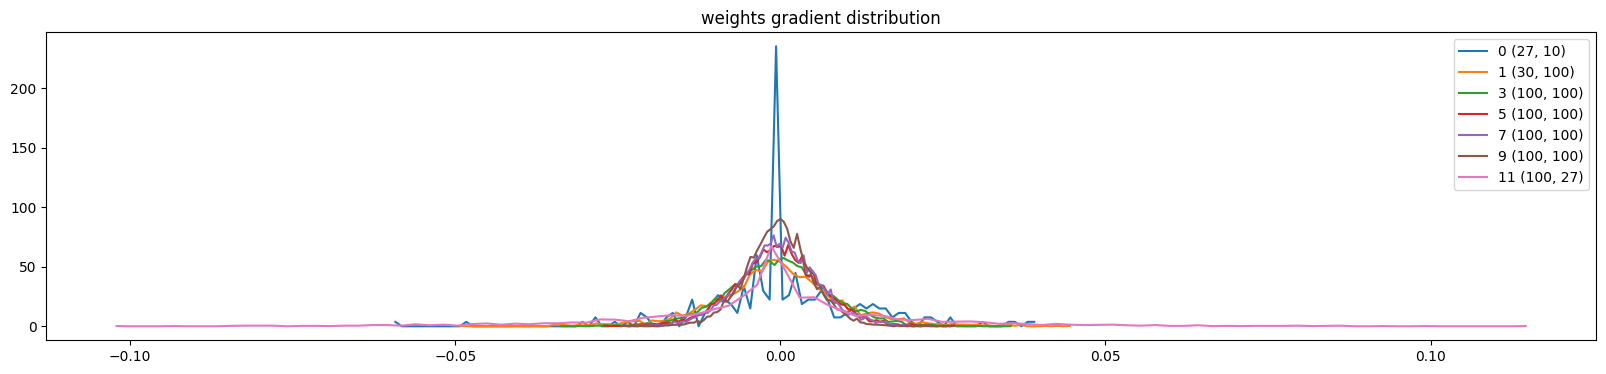

In [ ]:
"""
Solo estoy viendo los weights (no biases ni gammas ni betas of batchnorm)
Aca estamos viendo el ratio de gradient to data (a ver si los gradient son muy chicos o grandes comparados con los values posta)
"""

# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

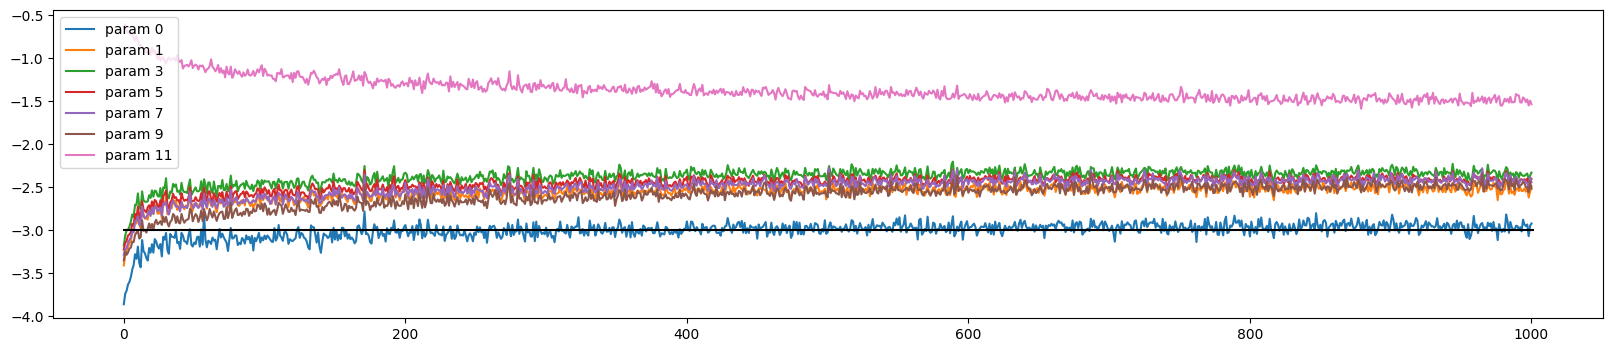

In [ ]:
"""
update/data (para ver la escala del update comparado a la data).
Tiene que estar encima de la linea pero no por tanto
"""

plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot # PARA QUE NO SEAN TAN GRANDES
plt.legend(legends);


### With BatchNorm (no gain)

Sirve para resolver el problema de la estabilizacion de la red.

Lo que vemos es que no importa si usamos gain o no gain, el batchnorm sirve para estabilizar la red

Tambien podriamos sacar la normalizacion por fan_in (pero hay que aumentar el learning rate)

In [ ]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) #/ fan_in**0.5 NUEVO: podriamos sacar esto porque usamos batchnorm
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]
  

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [ ]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1 # NUEVO: cambiamos el weight porque es batch norm
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3 # NUEVO aca no usamos gain

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [ ]:
# same optimization as last time
max_steps = 10_000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  """retain the gradient for a specific tensor. 
  Normally, PyTorch only keeps gradients for leaf nodes in the computation graph, which are typically the parameters of your model. 
  Non-leaf tensors are the results of operations in your network (like the output of a layer)."""
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 1.0 # NUEVO: aumento porque saque el normalizador con fan_in 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/  10000: 3.2870


layer 2 (      Tanh): mean +0.02, std 0.63, saturated: 3.91%
layer 5 (      Tanh): mean -0.01, std 0.63, saturated: 3.53%
layer 8 (      Tanh): mean -0.02, std 0.63, saturated: 3.09%
layer 11 (      Tanh): mean -0.01, std 0.63, saturated: 2.69%
layer 14 (      Tanh): mean +0.02, std 0.64, saturated: 3.34%


Text(0.5, 1.0, 'activation distribution')

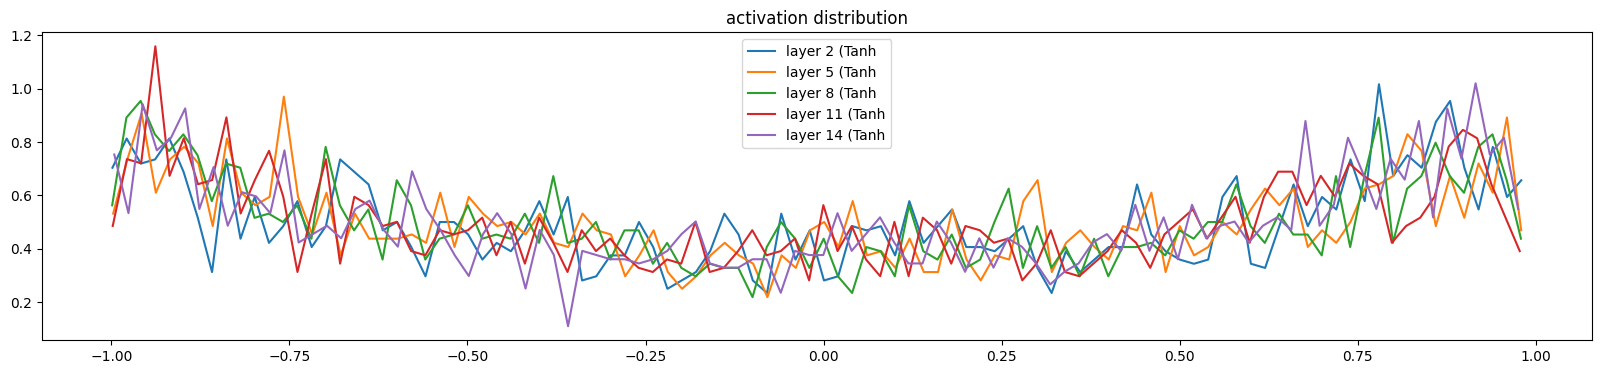

In [ ]:
# visualize histograms (para los tanh layers)

plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 4.081715e-03
layer 5 (      Tanh): mean +0.000000, std 3.513452e-03
layer 8 (      Tanh): mean -0.000000, std 3.458263e-03
layer 11 (      Tanh): mean +0.000000, std 3.407233e-03
layer 14 (      Tanh): mean -0.000000, std 3.295505e-03


Text(0.5, 1.0, 'gradient distribution')

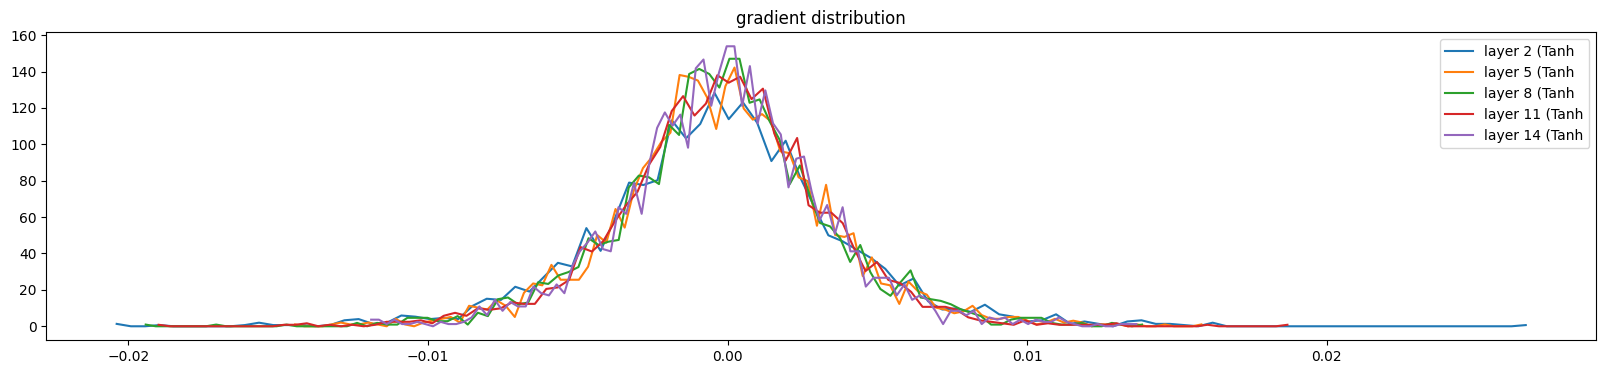

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 8.340202e-03 | grad:data ratio 8.083651e-03
weight  (30, 100) | mean +0.000061 | std 2.610466e-03 | grad:data ratio 2.540102e-03
weight (100, 100) | mean -0.000013 | std 1.353517e-03 | grad:data ratio 1.356913e-03
weight (100, 100) | mean -0.000005 | std 1.178780e-03 | grad:data ratio 1.169536e-03
weight (100, 100) | mean -0.000005 | std 1.124870e-03 | grad:data ratio 1.120831e-03
weight (100, 100) | mean +0.000006 | std 1.150513e-03 | grad:data ratio 1.145343e-03
weight  (100, 27) | mean -0.000025 | std 2.196452e-03 | grad:data ratio 2.218109e-03


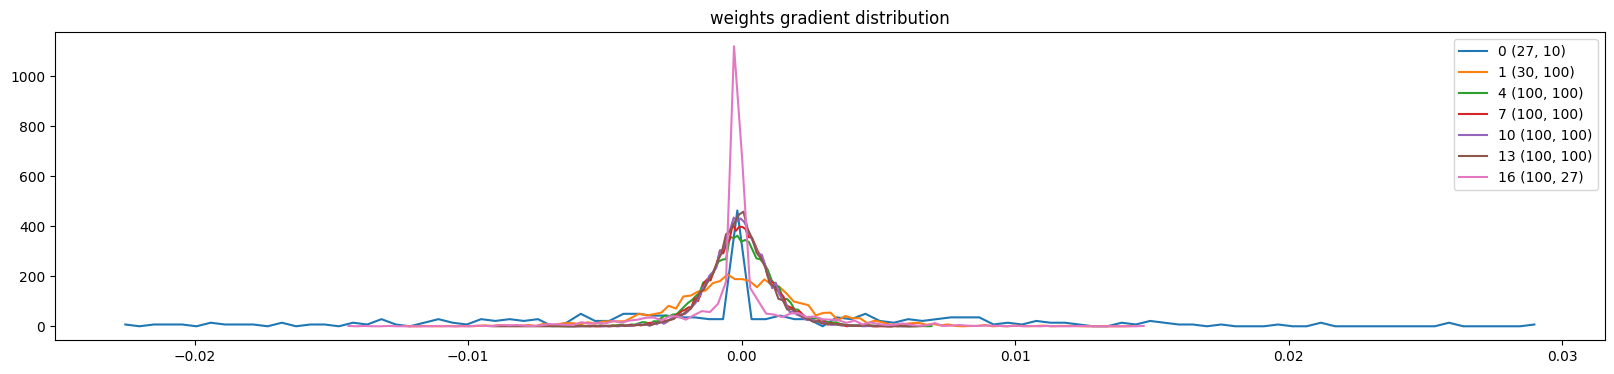

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

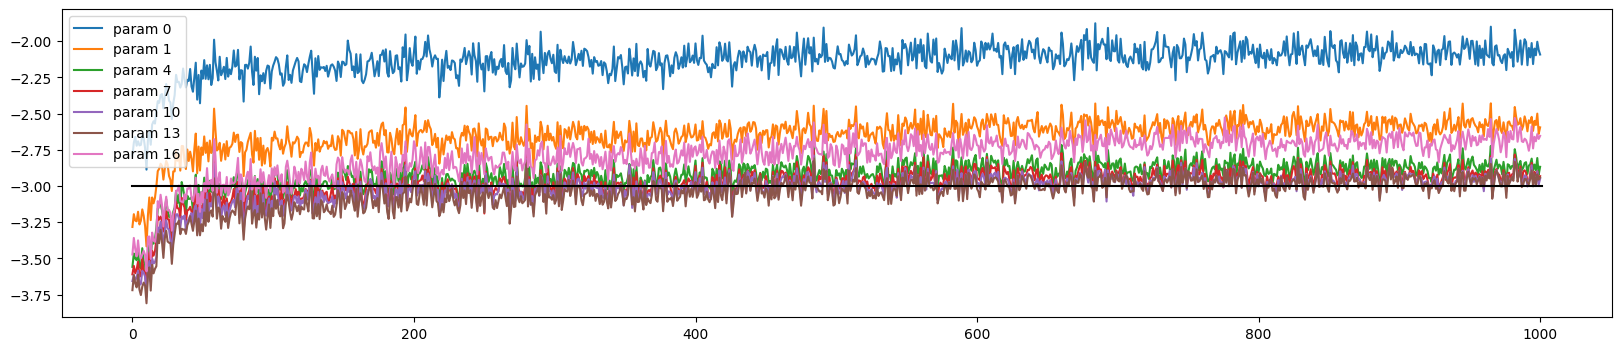

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


In [ ]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.4127321243286133
val 2.4115982055664062


### Sampling from model

In [ ]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word